In [10]:
bayesian_hdx_dir = '../../pyext/src'

import sys
sys.path.append(bayesian_hdx_dir)
import scoring, sampling, system, model, hxio, tools, analysis

#from pyopenms import *""
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [11]:
sequence = "MNMKKLATLVSAVALSATVSANAMAKDTIALVVSTLNNPFFVSLKDGAQKEADKLGYNLVVLDSQNNPAKELANVQDLTVRGTKILLINPTDSDAVGNAVKMANQANIPVITLDRQATKGEVVSHIASDNVLGGKIAGDYIAKKAGEGAKVIELQGIAGTSAARERGEGFQQAVAAHKFNVLASQPADFDRIKGLNVMQNLLTAHPDVQAVFAQNDEMALGALRALQTAGKSDVMVVGFDGTPDGEKAVNDGKLAATIAQLPDQIGAKGVETADKVLKGEKVQAKYPVDLKLVVKQ"

infile = "./data/bayesian_hdx_RBSB_1018_APO.dat"

In [12]:
dataset = hxio.import_HXcolumns(infile,
                                sequence,
                                name="APO",
                                percentD=True,
                                conditions=None,
                                error_estimate=0.5,
                                n_fastamides=0,
                                offset=0)


raw_spectra_path = '../rbsb/SpecExport_1018'

hxio.load_raw_ms_to_hdxms_data(dataset, raw_spectra_path)

tools.set_t0_rep_score(dataset)
tools.refine_dataset(dataset)

/home/chenlin/Documents/research_git/bayesian_hdx/v2/examples/rbsb_fulld/../../pyext/src/data.py:139: RuntimeWarning: divide by zero encountered in scalar divide
  fastest_logk = numpy.log10(-numpy.log(threshold)/first_time_point)


Standard Conditions used.  Please modify these in the script if you are not at 293K and pH=7


  0%|          | 0/129 [00:00<?, ?it/s]

100%|██████████| 129/129 [00:10<00:00, 11.92it/s]


Done loading raw MS data.
Set score for 280 t0 replicates
num of tps before refining:  1161
Refining dataset...
LVVSTLNNPFFVS 30.0 removed
LVVSTLNNPFFVS 1920.0 removed
LVVSTLNNPFFVS 7680.0 removed
LVVSTLNNPFFVSL 30.0 removed
LVVSTLNNPFFVSL 1920.0 removed
LVVSTLNNPFFVSL 7680.0 removed
VVSTLNNPFFVSL 30.0 removed
VVSTLNNPFFVSL 480.0 removed
VVSTLNNPFFVSL 1920.0 removed
VVSTLNNPFFVSL 7680.0 removed
TLNNPFFVSL 30.0 removed
TLNNPFFVSL 480.0 removed
TLNNPFFVSL 3840.0 removed
TLNNPFFVSL 15360.0 removed
VSLKDGAQKEADKLGYNL 30.0 removed
AQKEADKLGYN 30.0 removed
AQKEADKLGYN 7680.0 removed
VVLDSQNNPAKELANVQDL 30.0 removed
VVLDSQNNPAKELANVQDL 1920.0 removed
VVLDSQNNPAKELANVQDL 7680.0 removed
DSQNNPAKELANVQDL 30.0 removed
DSQNNPAKELANVQDL 7680.0 removed
NNPAKELANVQ 30.0 removed
NNPAKELANVQ 15360.0 removed
NNPAKELANVQDLTVRGTK 30.0 removed
NNPAKELANVQDLTVRGTK 1920.0 removed
NNPAKELANVQDLTVRGTK 7680.0 removed
ELANVQDL 30.0 removed
ANVQDLTVRGTKIL 30.0 removed
ANVQDLTVRGTKIL 7680.0 removed
VQDLTVRGTKIL 30

In [13]:
pep = dataset.peptides[0]

In [14]:
pep.num_observable_amides

6

In [15]:
# Initialize model
state_name = "test_run"
outputdir = "./output_test"
num_exp_bins = 14
nsteps =1000
sys = system.System(output_dir=outputdir, noclobber=False)
mol = sys.add_macromolecule(sequence, "Test", initialize_apo=False)


# Add states
if state_name is None:
    raise ValueError("Must provide a state name")
state = mol.add_state(f"{state_name}_1")
state.scoring_function = scoring.ScoringFunction(scoring.GaussianNoiseModelIsotope(state, truncated=False,)) 
state2 = mol.add_state(f"{state_name}_2")
state2.scoring_function = scoring.ScoringFunction(scoring.GaussianNoiseModelIsotope(state, truncated=False)) 

# Add data to molecule state
state.add_dataset(dataset)
state2.add_dataset(dataset)

sys.output.write_datasets()

output_model = model.ResidueGridModel(state, grid_size=num_exp_bins)
state.set_output_model(output_model)
state2.set_output_model(output_model)



DS ./output_test


/home/chenlin/Documents/research_git/bayesian_hdx/v2/examples/rbsb_fulld/../../pyext/src/data.py:139: RuntimeWarning: divide by zero encountered in scalar divide
  fastest_logk = numpy.log10(-numpy.log(threshold)/first_time_point)


In [16]:
output_model.protection_factors

False

In [17]:
sampler = sampling.MCSampler(sys, pct_moves=20, sigma_sample_level=None)

sys.output.initialize_output_model_file(state, output_model.pf_grids)
sys.output.initialize_output_model_file(state2, output_model.pf_grids)


annealing_steps=20 

sampler.run(annealing_steps, 100, find_temperature=False)

for i in range(5):
    sampler.run(annealing_steps, 20, find_temperature=False)
    sampler.run(200, 2, write=True, find_temperature=False)
# for i in range(5):
#     sampler.run(annealing_steps, 50, find_temperature=False)
#     #sampler.residue_sampler.set_adjacency(True, 3)
#     sampler.run(annealing_steps, 20, find_temperature=False)
#     sampler.run(annealing_steps, 10, find_temperature=False)
#     sampler.residue_sampler.set_adjacency(True, 4)
#     sampler.run(annealing_steps, 5, find_temperature=False)
#     # This temperature tends to sit around 15% MC acceptance rate, which seems to be good.
#     sampler.run(nsteps, 2, write=True, find_temperature=False)
#     sampler.run(20, 0.1, write=True, find_temperature=False)

#pof = analysis.ParseOutputFile(outputdir + f"/models_scores_sigmas-{state_name}_1.dat")
#pof2 = analysis.ParseOutputFile(outputdir + f"/models_scores_sigmas-{state_name}_2.dat")
#pof.generate_datasets()
#pof2.generate_datasets()
#pof.calculate_random_sample_convergence()
#pof2.calculate_random_sample_convergence()

#conv = analysis.Convergence(pof, pof2)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/chenlin/anaconda3/envs/MD/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_128232/4149460635.py", line 1, in <module>
    sampler = sampling.MCSampler(sys, pct_moves=20, sigma_sample_level=None)
  File "/home/chenlin/Documents/research_git/bayesian_hdx/v2/examples/rbsb_fulld/../../pyext/src/sampling.py", line 222, in __init__
    s.initialize()
  File "/home/chenlin/Documents/research_git/bayesian_hdx/v2/examples/rbsb_fulld/../../pyext/src/system.py", line 468, in initialize
    self.calculate_peptides_score(self.get_all_peptides(), self.output_model.model_protection_factors)
  File "/home/chenlin/Documents/research_git/bayesian_hdx/v2/examples/rbsb_fulld/../../pyext/src/system.py", line 485, in calculate_peptides_score
    return self.scoring_function.evaluate(protection_factors, peptides)
  File "/home/chenlin/Documents/re

In [32]:
p1 = np.array([8.42911538e+01,1.82567165e+03,-3.78146503e+03,1.69027390e+03
,4.41428676e+02,-5.48201114e+02,2.75498216e+02,1.34414665e+01
,6.10636307e-02,1.99211337e-05,3.65281143e-10,1.36347030e-15])

p2= np.array([0.01438017,0.14913024,0.19725778,0.04683114,0.3693501,0.04132925
,0.11097312,0.05025508,0.02049313])

In [28]:
p1 = np.abs(p1)

In [34]:
# num of the negative values
print(np.sum(p2<0))

0


In [29]:
x1, x2 = tools.norm_pad_two_arrays(p1, p2)

In [30]:
tools.custom_kl_divergence(x1, x2)

0.5755432594126196

In [18]:
tools.get_divergence(p1, p2, method='KL')

nan

In [9]:
state.scoring_function.forward_model.replicate_score(p1,p2, 0.3)

[84.2911538, 1825.67165, -3781.46503, 1690.2739, 441.428676, -548.201114, 275.498216, 13.4414665, 0.0610636307, 1.99211337e-05, 3.65281143e-10, 1.3634703e-15] [0.01438017, 0.14913024, 0.19725778, 0.04683114, 0.3693501, 0.04132925, 0.11097312, 0.05025508, 0.02049313] 0.3


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<function sum at 0x7fa8d062ab00>) found for signature:
 
 >>> sum(reflected list(float64)<iv=None>)
 
There are 2 candidate implementations:
[1m   - Of which 2 did not match due to:
   Overload of function 'sum': File: numba/core/typing/npydecl.py: Line 373.
     With argument(s): '(reflected list(float64)<iv=None>)':[0m
[1m    No match.[0m
[0m
[0m[1mDuring: resolving callee type: Function(<function sum at 0x7fa8d062ab00>)[0m
[0m[1mDuring: typing of call at /home/chenlin/Documents/research_git/bayesian_hdx/v2/examples/rbsb_fulld/../../pyext/src/tools.py (735)
[0m
[1m
File "../../pyext/src/tools.py", line 735:[0m
[1mdef norm_pad_two_arrays(p, q):
    <source elided>
    '''
[1m    x1 = p / np.sum(p)
[0m    [1m^[0m[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function norm_pad_two_arrays at 0x7fa7f533f490>))[0m
[0m[1mDuring: typing of call at /home/chenlin/Documents/research_git/bayesian_hdx/v2/examples/rbsb_fulld/../../pyext/src/tools.py (747)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function norm_pad_two_arrays at 0x7fa7f533f490>))[0m
[0m[1mDuring: typing of call at /home/chenlin/Documents/research_git/bayesian_hdx/v2/examples/rbsb_fulld/../../pyext/src/tools.py (747)
[0m
[1m
File "../../pyext/src/tools.py", line 747:[0m
[1mdef get_divergence(p, q, method='KL'):
    <source elided>
    
[1m    x1, x2 = norm_pad_two_arrays(p, q)
[0m    [1m^[0m[0m


In [8]:
model.

array([ 6.42308967e-03, -5.74125946e-01,  1.16404636e+00,  3.70208828e-01,
        3.26523604e-02,  7.95273983e-04,  3.90975387e-08,  1.03964237e-13,
        5.55773690e-20,  5.06215064e-27,  2.27193746e-35])

In [7]:
for pep in dataset.peptides:
    if pep.sequence == 'HKFNVL':
        for tp in pep.timepoints:
            if tp.time == 30.0:
                for rep in tp.replicates:
                    if rep.charge_state == 2:
                        break

In [8]:
import pyopenms as oms

def get_isotope_envelope(replicate):
    #print(f'{replicate.peptide.sequence} {replicate.timepoint.time} {replicate.charge_state}')
    # Step 1: Centroiding
    seq = oms.AASequence.fromString(replicate.peptide.sequence) 
    mfull = seq.getMonoWeight()
    mz_values = replicate.raw_ms['m/z'].values - mfull/float(replicate.charge_state)
    intensities = replicate.raw_ms['Intensity'].values 

    spectrum = oms.MSSpectrum()
    spectrum.set_peaks((mz_values, intensities))
    picker = oms.PeakPickerHiRes()
    picked_spectrum = oms.MSSpectrum()
    picker.pick(spectrum, picked_spectrum)

    mz_picked, intensity_picked = picked_spectrum.get_peaks()
    df_picked = pd.DataFrame({'m/z': mz_picked, 'Intensity': intensity_picked})
    return df_picked

In [16]:
tools.get_isotope_envelope(rep)

,m/z,Intensity
0,0.0,0.0


In [10]:
rep.isotope_envelope

array([nan])

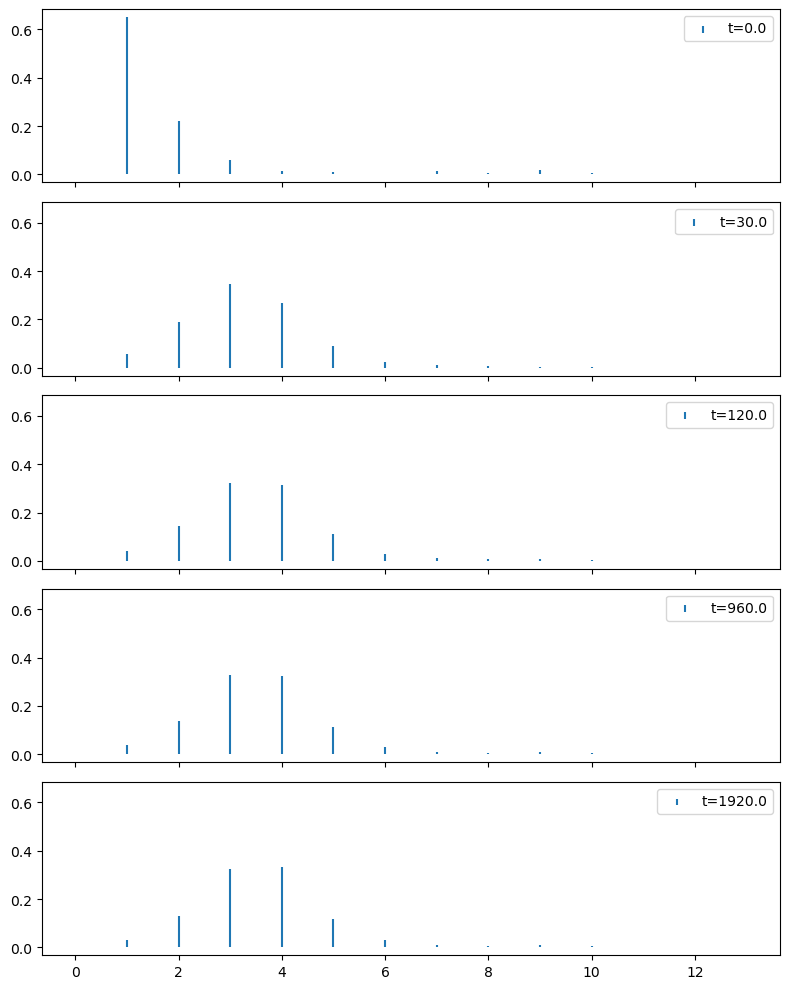

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 1,figsize=(8,10), sharex=True, sharey=True)

for i,rep in enumerate([rep for tp in pep.timepoints for rep in tp.get_replicates() if rep.charge_state == pep.best_charge_state][:5]):
    ax = axes.flatten()[i]

    isotope_envelope = tools.get_isotope_envelope(rep)
    ax.stem(isotope_envelope['m/z'],isotope_envelope['Intensity'], linefmt='-', markerfmt=' ', basefmt=" ", label=f't={rep.timepoint.time}')
    #sns.lineplot(x='m/z', y='Intensity', data=tp.raw_ms, linewidth=1.0)

    ax.legend()
    #ax.set_ylim(0, 0.3)


plt.tight_layout()